# CatBoost Training Pipeline

This notebook demonstrates the full training pipeline for bank scoring models.

## Features
- Group-aware train/valid/OOS/OOT splitting (one client in one split only)
- Optional sample balancing by groups (e.g., product types)
- Automated preprocessing (Decimal handling, date transformation, type detection)
- Feature selection (missing, variance, correlation, PSI, importance filters)
- Hyperparameter optimization with Optuna
- Comprehensive evaluation and visualization

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import PipelineConfig, FeatureSelectionConfig
from src.pipeline import CatBoostPipeline
from src.data import DataLoader

## 1. Load Data

Load your data from Spark parquet files.

In [2]:
# Option 1: Load from parquet
# loader = DataLoader()
# df = loader.load_parquet('/path/to/your/data.parquet')

# Option 2: Generate sample data for demonstration
np.random.seed(42)
n_samples = 10000
n_clients = 2000

# Client IDs (one client can have multiple observations)
client_ids = np.random.choice(range(n_clients), size=n_samples)

# Dates over 6 months
dates = pd.date_range('2024-01-01', periods=180, freq='D')
report_dates = np.random.choice(dates, size=n_samples)

# Generate features
df = pd.DataFrame({
    'client_id': client_ids,
    'application_id': range(n_samples),
    'report_date': report_dates,
    'product_type': np.random.choice(['PK', 'KK', 'IK'], size=n_samples, p=[0.8, 0.18, 0.02]),
    'income': np.random.lognormal(10, 1, n_samples),
    'age': np.random.randint(18, 70, n_samples),
    'credit_score': np.random.randint(300, 850, n_samples),
    'debt_ratio': np.random.uniform(0, 1, n_samples),
    'num_accounts': np.random.randint(0, 10, n_samples),
    'employment_years': np.random.exponential(5, n_samples),
    'region': np.random.choice(['Moscow', 'SPB', 'Other'], size=n_samples, p=[0.3, 0.2, 0.5]),
})

# Generate target correlated with features
logit = (
    -0.001 * df['income'] / 1000 +
    -0.02 * df['age'] +
    -0.005 * df['credit_score'] +
    2 * df['debt_ratio'] +
    0.1 * df['num_accounts'] +
    -0.05 * df['employment_years'] +
    np.random.randn(n_samples) * 0.5
)
prob = 1 / (1 + np.exp(-logit))
df['target'] = (np.random.random(n_samples) < prob).astype(int)

print(f'Data shape: {df.shape}')
print(f'Target rate: {df["target"].mean():.2%}')
df.head()

Data shape: (10000, 12)
Target rate: 11.46%


,client_id,application_id,report_date,product_type,income,age,credit_score,debt_ratio,num_accounts,employment_years,region,target
0,1126,0,2024-04-03,PK,48117.032584,46,385,0.312834,2,10.735114,Moscow,0
1,1459,1,2024-01-19,PK,19464.116191,24,535,0.014766,6,1.612854,Moscow,1
2,860,2,2024-01-23,PK,7542.295975,64,714,0.660563,3,1.457245,Moscow,0
3,1294,3,2024-02-23,PK,49901.046254,43,655,0.232448,4,1.490667,Other,0
4,1130,4,2024-03-05,PK,12547.764914,23,547,0.566736,2,0.502890,SPB,0


## 2. Configure Pipeline

Set up pipeline configuration.

In [3]:
# Basic configuration
config = PipelineConfig(
    id_columns=['client_id', 'application_id'],
    date_column='report_date',
    target_column='target',
    client_column='client_id',  # For group-aware splitting
    random_seed=42,
    
    # Split ratios
    train_ratio=0.6,
    valid_ratio=0.2,
    oos_ratio=0.1,
    oot_ratio=0.1,
    
    # Feature selection thresholds
    missing_threshold=0.95,
    correlation_threshold=0.95,
    psi_threshold=0.25,
    
    # Optuna settings
    n_trials=50,
    optuna_timeout=600,  # 10 minutes
    
    # Artifacts
    artifacts_dir='./artifacts'
)

# Optional: Configuration with balancing by product type
config_balanced = PipelineConfig(
    id_columns=['client_id', 'application_id'],
    date_column='report_date',
    target_column='target',
    client_column='client_id',
    balance_columns=['product_type'],  # Balance by product type
    random_seed=42,
    n_trials=50,
    optuna_timeout=600,
    artifacts_dir='./artifacts_balanced'
)

# Feature selection configuration
selection_config = FeatureSelectionConfig(
    run_missing_filter=True,
    run_variance_filter=True,
    run_correlation_filter=True,
    run_psi_filter=True,
    run_importance_filter=True,
    run_backward_selection=False,  # Optional, slower
    run_forward_selection=False,   # Optional, slowest
)

## 3. Train Pipeline

Run the full training pipeline.

In [4]:
# Initialize and train pipeline
pipeline = CatBoostPipeline(config, selection_config)

# Fit with hyperparameter optimization
pipeline.fit(df, run_optimization=True, save_artifacts=True)

/Users/kpaq/Documents/code/AutoML/src/preprocessing/date_transformer.py:90: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(sample, errors='raise')
/Users/kpaq/Documents/code/AutoML/src/preprocessing/date_transformer.py:90: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(sample, errors='raise')
[I 2026-01-28 15:26:02,245] A new study created in memory with name: no-name-6e62a909-8bcd-40c4-bc2b-ede910daa7a1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-28 15:26:02,982] Trial 0 finished with value: 0.7506123919308357 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.1205712628744377, 'l2_leaf_reg': 6.387926357773329, 'min_data_in_leaf': 16, 'grow_policy': 'Lossguide', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9849549260809971, 'random_strength': 8.324426408004218}. Best is trial 0 with value: 0.7506123919308357.
[I 2026-01-28 15:26:03,399] Trial 1 finished with value: 0.7574516261836147 and parameters: {'iterations': 291, 'depth': 5, 'learning_rate': 0.018659959624904923, 'l2_leaf_reg': 3.7381801866358395, 'min_data_in_leaf': 53, 'grow_policy': 'Lossguide', 'bootstrap_type': 'MVS', 'random_strength': 4.56069984217036}. Best is trial 1 with value: 0.7574516261836147.
[I 2026-01-28 15:26:03,626] Trial 2 finished with value: 0.7582672910662824 and parameters: {'iterations': 807, 'depth': 5, 'learning_rate': 0.05748924681991978, 'l2_leaf_reg': 6.331731119758382, 'min_data_in_leaf': 5, 'grow_policy': 'Symme

## 4. View Results

In [5]:
# Get metrics
metrics = pipeline.get_metrics()

print('=== Model Performance ===')
for split, split_metrics in metrics.items():
    gini = split_metrics.get('gini', 0)
    auc = split_metrics.get('auc', 0)
    n = split_metrics.get('n_samples', 0)
    print(f'{split.upper():6s}: Gini={gini:.4f}, AUC={auc:.4f}, N={n:,}')

=== Model Performance ===
TRAIN : Gini=0.5385, AUC=0.7692, N=5,895
VALID : Gini=0.5303, AUC=0.7652, N=1,959
OOS   : Gini=0.5515, AUC=0.7757, N=989
OOT   : Gini=0.5476, AUC=0.7738, N=1,157


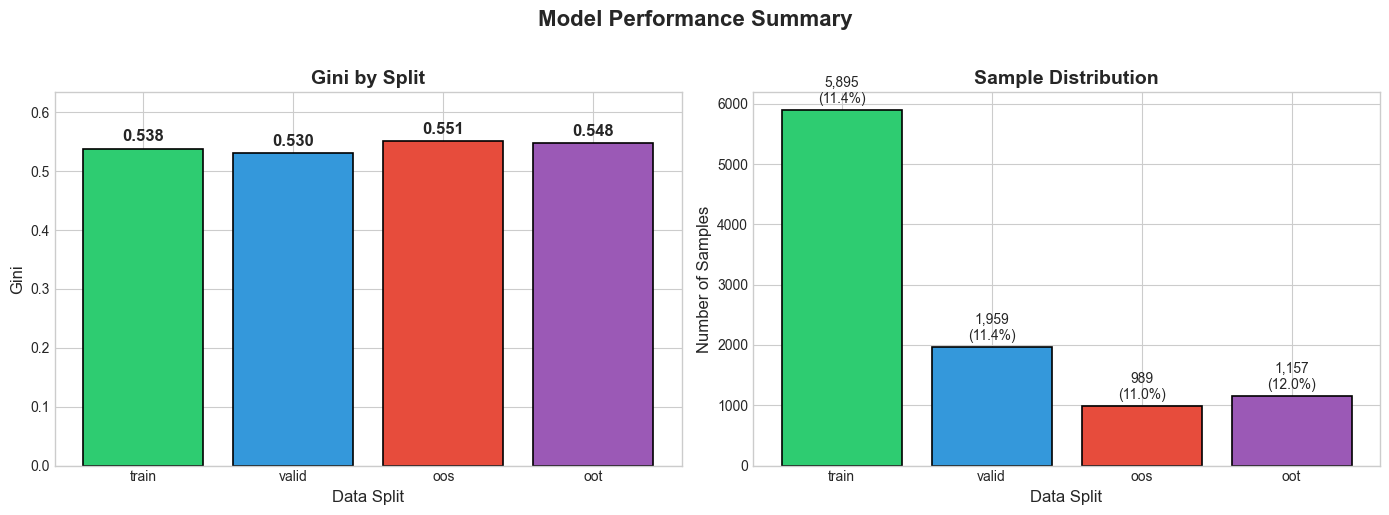

In [6]:
# Plot metrics summary
fig = pipeline.plot_metrics()
plt.show()

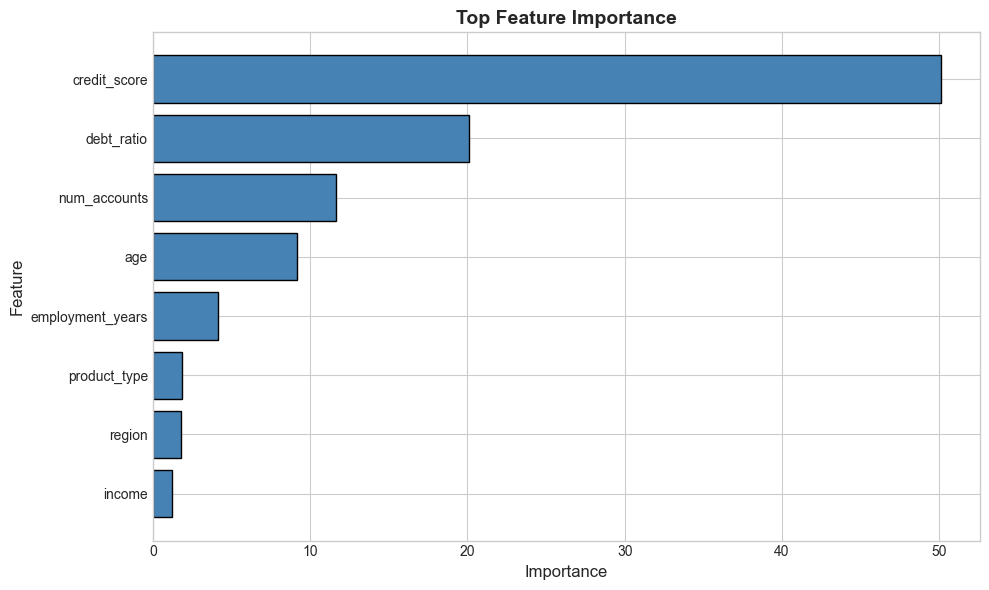

In [7]:
# Feature importance
fig = pipeline.plot_feature_importance(top_n=15)
plt.show()

,auc,gini,avg_precision,n_samples,n_positive,n_negative,target_rate,period
0,0.692130,0.384259,0.284665,159,15,144,0.094340,2024-01
1,0.681585,0.363170,0.325968,158,15,143,0.094937,2024-02
2,0.755915,0.511830,0.306155,180,21,159,0.116667,2024-03
3,0.781480,0.562959,0.314074,170,13,157,0.076471,2024-04
4,0.822742,0.645485,0.628190,141,26,115,0.184397,2024-05
5,0.818367,0.636735,0.493586,349,49,300,0.140401,2024-06


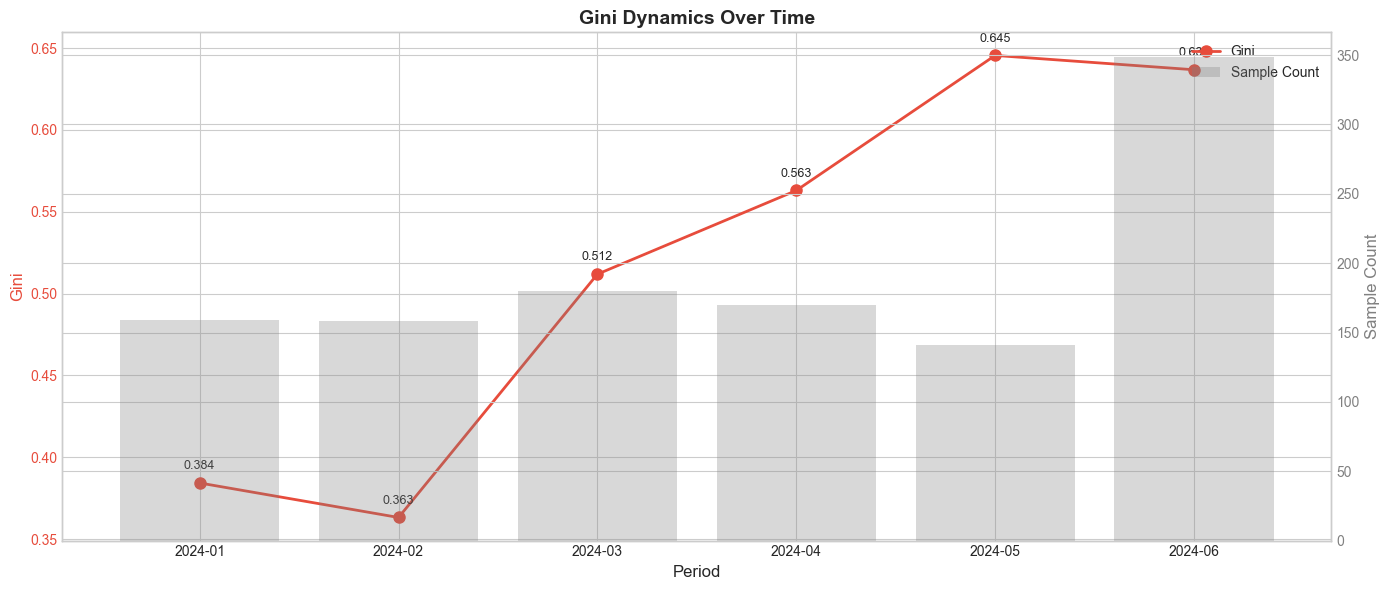

In [8]:
# Time dynamics (for OOT split)
time_metrics = pipeline.calculate_time_metrics('oot')
display(time_metrics)

fig = pipeline.plot_time_dynamics('oot')
plt.show()

## 5. Feature Importance Analysis

In [9]:
# Get feature importance DataFrame
importance_df = pipeline.get_feature_importance()
print('Top 10 Features:')
display(importance_df.head(10))

Top 10 Features:


,feature,importance
0,credit_score,50.085132
1,debt_ratio,20.084491
2,num_accounts,11.679031
3,age,9.196241
4,employment_years,4.125425
5,product_type,1.829854
6,region,1.796681
7,income,1.203144


## 6. Predictions

In [10]:
# Make predictions on new data
predictions = pipeline.predict(df.head(100))
print(f'Predictions shape: {predictions.shape}')
print(f'Mean prediction: {predictions.mean():.4f}')

Predictions shape: (100,)
Mean prediction: 0.1842


## 7. Training with Balancing

Train with sample weighting by product type.

In [11]:
# Check product distribution
print('Product distribution:')
print(df['product_type'].value_counts(normalize=True))

Product distribution:
product_type
PK    0.7968
KK    0.1804
IK    0.0228
Name: proportion, dtype: float64


In [12]:
# Train with balancing
pipeline_balanced = CatBoostPipeline(config_balanced, selection_config)
pipeline_balanced.fit(df, run_optimization=False, save_artifacts=True)

# View metrics by group
metrics_balanced = pipeline_balanced.get_metrics()

print('=== Metrics by Product Type ===')
for split in ['train', 'valid', 'oos', 'oot']:
    print(f'\n{split.upper()}:')
    gini_by_group = metrics_balanced[split].get('gini_by_group', {})
    for group, gini in gini_by_group.items():
        print(f'  {group}: Gini={gini:.4f}')

/Users/kpaq/Documents/code/AutoML/src/preprocessing/date_transformer.py:90: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(sample, errors='raise')
/Users/kpaq/Documents/code/AutoML/src/preprocessing/date_transformer.py:90: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(sample, errors='raise')


=== Metrics by Product Type ===

TRAIN:
  PK: Gini=0.5556
  KK: Gini=0.7277
  IK: Gini=1.0000

VALID:
  PK: Gini=0.4518
  KK: Gini=0.5356
  IK: Gini=0.4133

OOS:
  PK: Gini=0.5599
  KK: Gini=0.4272
  IK: Gini=0.1579

OOT:
  PK: Gini=0.5082
  KK: Gini=0.4746
  IK: Gini=0.2632
